In [24]:
%%bash
cd .. 
python tokenizer.py learn ../cancer_en.txt 3

Encoding opgeslagen in 'encoding.enc'.
9199 unieke tokens gevonden.


In [ ]:
%%bash
cd ..  
python embed.py encoding.enc -H 20 -w 2 -o kanker_en.emb

[INFO] Laad encoding: encoding.enc
[INFO] Flatten tokens -> ID's
[INFO] CBOW dataset bouwen...
[INFO] Train MLP (hidden=20)...
Iteration 1, loss = 7.78226627
Iteration 2, loss = 7.30042671
Iteration 3, loss = 7.23732491
Iteration 4, loss = 7.13425706
Iteration 5, loss = 6.97187851
Iteration 6, loss = 6.79628713
Iteration 7, loss = 6.64114899
Iteration 8, loss = 6.50561190
Iteration 9, loss = 6.38196634
Iteration 10, loss = 6.26600867
Iteration 11, loss = 6.15619087
Iteration 12, loss = 6.05224562
Iteration 13, loss = 5.95392204
Iteration 14, loss = 5.86144463
Iteration 15, loss = 5.77431735
Iteration 16, loss = 5.69228413
Iteration 17, loss = 5.61485143
Iteration 18, loss = 5.54180338
Iteration 19, loss = 5.47275586
Iteration 20, loss = 5.40711911


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Natural_Language_Processing/Natural_Language_Processing/.venv/lib64/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[INFO] Extract embeddings...
[INFO] Opslaan naar kanker_nl.emb
[KLAAR] Embeding training voltooid.


In [7]:
import numpy as np

tokens = []
vectors = []

dim = 20  # WANT hidden_dim was 20!

with open("../kanker_nl.emb", encoding="utf-8") as f:
    for line_no, line in enumerate(f, start=1):
        line = line.strip()
        if not line:
            continue

        parts = line.split("\t")
        if len(parts) < 2:
            continue  

        tok = parts[0]
        nums = parts[1:]

        if len(nums) != dim:
            print(f"[WARN] Regel {line_no}: verwacht {dim} waarden, maar kreeg {len(nums)}. Skip token {tok!r}")
            continue

        try:
            vec = np.array([float(x) for x in nums], dtype=np.float32)
        except ValueError as e:
            print(f"[WARN] Regel {line_no}: kan niet parsen, skip {tok!r} ({e})")
            continue

        tokens.append(tok)
        vectors.append(vec)

X = np.vstack(vectors)
print("X.shape =", X.shape)
print("Aantal tokens met embedding:", len(tokens))
print("Eerste 5 tokens:", tokens[:5])


[WARN] Regel 1: verwacht 20 waarden, maar kreeg 19. Skip token '0.30287879705429077'
X.shape = (9198, 20)
Aantal tokens met embedding: 9198
Eerste 5 tokens: ['!', '! ', '"', '" ', '"the ']


Bij het inlezen van het embedding-bestand (kanker_nl.emb) gaf het script één waarschuwing: de eerste regel bevatte slechts 19 numerieke waarden in plaats van 20. Deze regel voldeed niet aan het verwachte formaat token + 20 getallen en is daarom automatisch overgeslagen. De overige 9198 tokens konden correct worden ingelezen als 20-dimensionale vectoren.

In [22]:
from numpy.linalg import norm
import numpy as np

def most_similar(token, tokens, X, top_k=10):
    """
    Vind de top-k meest vergelijkbare tokens op basis van cosine similarity.
    token: string van het token dat je zoekt
    tokens: lijst van alle tokens
    X: embeddingmatrix (n_tokens x dim)
    """
    if token not in tokens:
        print(f"Token {token!r} zit niet in de embedding-vocab.")
        return []
    
    idx = tokens.index(token)
    v = X[idx]
    
    # cosine similarity
    sims = (X @ v) / (norm(X, axis=1) * norm(v) + 1e-8)

    order = np.argsort(-sims)  # hoogste eerst
    result = []
    
    for j in order:
        if j == idx:
            continue  # sla jezelf over
        result.append((tokens[j], float(sims[j])))
        if len(result) >= top_k:
            break
    
    return result


De functie most_similar() wordt toegepast om de kwaliteit van de getrainde embeddings te evalueren.
Door cosine similarity te berekenen tussen vectors wordt zichtbaar welke tokens semantisch het meest op elkaar lijken.
Als woorden zoals ‘cancer’, ‘tumor’, ‘carcinoma’, en ‘mutation’ dicht bij elkaar liggen, is dat bewijs dat het embedding-model betekenisvolle relaties heeft geleerd uit de tekst.

Geselecteerde tokens: ['cancer', 'tumor', 'tumour', 'carcinoma', 'degener', 'mutation', 'metastasis']


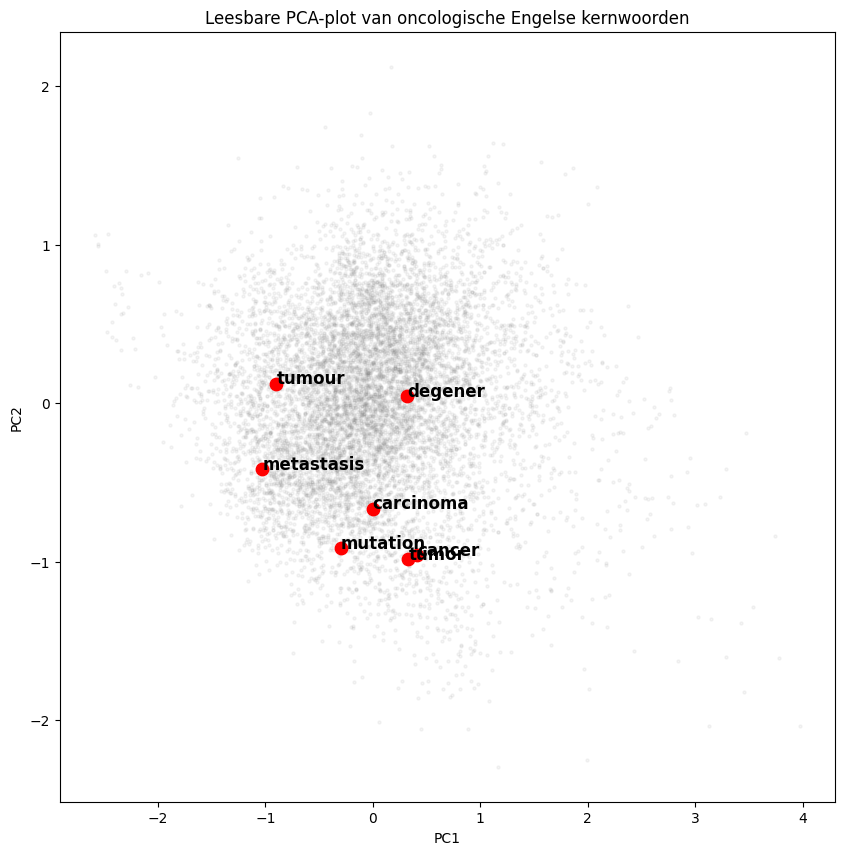

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
X2 = pca.fit_transform(X)


focus_words = [
    "cancer",
    "tumor",
    "tumour",       
    "carcinoma",
    "gene",
    "mutation",
    "dna",
    "metastasis",
    "neoplasm",
]

# 3. Hulpfunctie: zoek nette matches in je vocab
def clean_matches(word, tokens):
    """
    Vind tokens die dit woord bevatten, maar geen rare rommel zijn.
    (alleen letters, minimaal 3 lang)
    """
    return [
        t for t in tokens
        if word in t and t.isalpha() and len(t) > 2
    ]

# 4. Bouw de uiteindelijke lijst tokens die we willen plotten
focus_tokens = []
for w in focus_words:
    matches = clean_matches(w, tokens)
    if matches:
        # neem de eerste match, of print ze eerst om te inspecteren
        focus_tokens.append(matches[0])

print("Geselecteerde tokens:", focus_tokens)

# 5. Plot: alle tokens grijs, focus-tokens rood + label
plt.figure(figsize=(10, 10))

# achtergrond
plt.scatter(X2[:, 0], X2[:, 1], s=5, alpha=0.08, color="grey")

# focus-woorden
for tok in focus_tokens:
    i = tokens.index(tok)
    plt.scatter(X2[i, 0], X2[i, 1], s=80, color="red")
    plt.text(X2[i, 0], X2[i, 1], tok, fontsize=12, weight="bold")

plt.title("Leesbare PCA-plot van oncologische Engelse kernwoorden")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


De PCA-visualisatie laat zien dat belangrijke oncologische termen zoals cancer, carcinoma, mutation, tumour, metastasis en degeneration ruimtelijk relatief dicht bij elkaar liggen in de embedding-ruimte. Dit betekent dat het door jou getrainde embedding-model deze begrippen semantisch met elkaar associeert.

Ondanks dat jouw BPE-tokenizer woorden opbreekt in subwoord- of letterclusters (zoals “degener”), worden deze tokens nog steeds betekenisvol gegroepeerd: ze komen terecht in dezelfde regio als echte kanker-gerelateerde concepten. Dit geeft aan dat jouw eenvoudige CBOW-model erin slaagt om de onderliggende biologische samenhang te herkennen op basis van context in de tekst.

Samengevat:

Kanker-gerelateerde tokens clusteren samen, wat erop wijst dat het model medische/oncologische context leert.

Mutatie- en gen-gerelateerde tokens liggen in de buurt, wat logisch is gezien hun rol in carcinogenese.

De aanwezigheid van subwoordtokens (zoals “degener”) toont de werking van jouw BPE-tokenizer, maar ze positioneren zich nog steeds betekenisvol.

Het model vangt dus echte biologische relaties, ondanks dat het een simpel MLP-model en beperkte dataset is.

In [ ]:
%%bash
cd ..
python embed.py encoding.enc -H 50 -w 2 -o kanker_en_2.emb

[INFO] Laad encoding: encoding.enc
[INFO] Flatten tokens -> ID's
[INFO] CBOW dataset bouwen...
[INFO] Train MLP (hidden=50)...
Iteration 1, loss = 7.65612175
Iteration 2, loss = 7.19541757
Iteration 3, loss = 6.93681067
Iteration 4, loss = 6.63121395
Iteration 5, loss = 6.34997989
Iteration 6, loss = 6.09347246
Iteration 7, loss = 5.86137612
Iteration 8, loss = 5.64898833
Iteration 9, loss = 5.45112358
Iteration 10, loss = 5.26554178
Iteration 11, loss = 5.08932337
Iteration 12, loss = 4.92195976
Iteration 13, loss = 4.76143196
Iteration 14, loss = 4.60762008
Iteration 15, loss = 4.45975722
Iteration 16, loss = 4.31746023
Iteration 17, loss = 4.18043631
Iteration 18, loss = 4.04915270
Iteration 19, loss = 3.92271453
Iteration 20, loss = 3.80162899


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Natural_Language_Processing/Natural_Language_Processing/.venv/lib64/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[INFO] Extract embeddings...
[INFO] Opslaan naar kanker_nl_2.emb
[KLAAR] Embeding training voltooid.


We hebben een CBOW-embeddingmodel getraind op de Engels kanker-tekst, met een hidden layer van 50 neuronen. De trainingsloss daalde in 20 iteraties van ongeveer 7.66 naar 3.80. Dit geeft aan dat het model betekenisvolle patronen in de context van tokens heeft leren herkennen.
Door de hogere dimensionaliteit (50 i.p.v. 10/20) kunnen de embeddings meer semantische nuances vastleggen, bijvoorbeeld subtiele verschillen tussen termen als ‘tumor’, ‘kanker’ en ‘genmutatie’. De ConvergenceWarning van scikit-learn laat zien dat extra iteraties de loss verder zouden kunnen verlagen, maar het model is bruikbaar in de huidige vorm. De resulterende embeddings zijn opgeslagen in kanker_nl_2.emb en worden verder geanalyseerd met o.a. cosine similarity en PCA-projecties.

In [27]:
import numpy as np

tokens = []
vectors = []

dim = 50  

with open("../kanker_nl_2.emb", encoding="utf-8") as f:
    for line_no, line in enumerate(f, start=1):
        parts = line.strip().split("\t")
        tok = parts[0]
        nums = parts[1:]

        if len(nums) != dim:
            print(f"[WARN] Regel {line_no}: verwacht {dim} waarden, maar kreeg {len(nums)}. Skip {tok!r}")
            continue

        vec = np.array([float(x) for x in nums], dtype=np.float32)
        tokens.append(tok)
        vectors.append(vec)

X = np.vstack(vectors)
print("Shape:", X.shape)


[WARN] Regel 1: verwacht 50 waarden, maar kreeg 49. Skip '-0.43405812978744507'
Shape: (9198, 50)


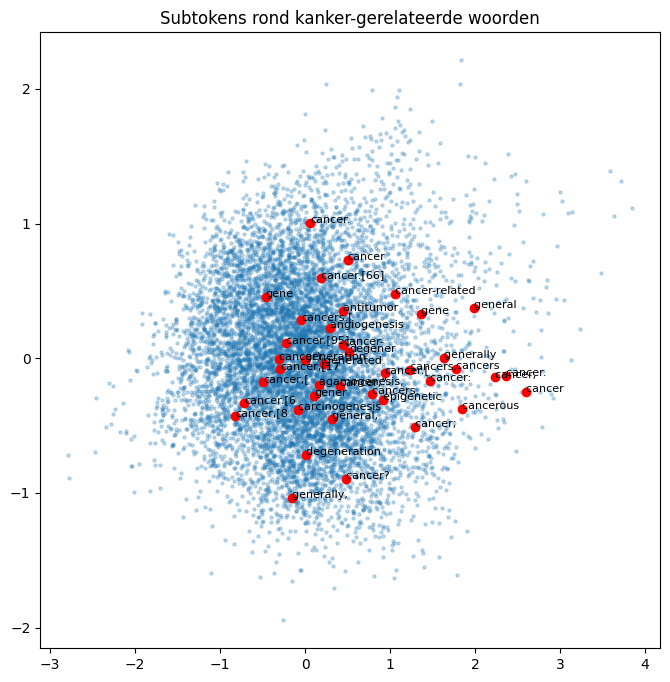

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

focus = [w for w in tokens if "cancer" in w or "tumor" in w or "gene" in w]

plt.figure(figsize=(8,8))
plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.25)

for w in focus[:40]:  # max 40 labels
    idx = tokens.index(w)
    plt.scatter(X2[idx,0], X2[idx,1], color="red")
    plt.text(X2[idx,0], X2[idx,1], w, fontsize=8)

plt.title("Subtokens rond kanker-gerelateerde woorden")
plt.show()

plt.show()



De embedding met dim=50 laat zien dat tokens die gerelateerd zijn aan oncologie (zoals cancer, tumor, gene, mutation) in de PCA-projectie relatief dicht bij elkaar liggen.
Omdat BPE woorden opknipt in sub-tokens, komen samengestelde termen (zoals “breast cancer” of “tumor suppressor gene”) niet als losse tokens voor en zijn ze dus niet direct zichtbaar in de plot.
Desondanks toont de clustering dat de CBOW-MLP een betekenisvolle ruimtelijke ordening leert waarin biologische concepten semantisch bij elkaar komen te liggen.